### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting
from skopt.space import Categorical, Integer, Real 

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_hparams = os.path.join(path, 'mean_hparams')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_hparams)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest_AD_vs_CN']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass
    
    path_hparams2 = os.path.join(path_hparams, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_hparams2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].transform(impute_mean)

### Search for hyperparams

In [8]:
final_cols = ['diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'moca_vs','ace_vs', 'functionality', 'marital_status',
              'n_children', 'household_members', 'household_income', 'Job_status']

final_cols2 = ['diagnosis', 'ifs_total_score', 'mini_sea_total', 'npi_total',
               'npi_total_caregiver', 'mmse_vs', 'moca_vs','ace_vs', 'functionality' ]

final_cols3 = ['diagnosis', 'year_birth', 'sex', 'years_education','ifs_total_score',
               'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'cognition',
               'functionality', 'marital_status', 'n_children', 'household_members',
               'household_income', 'Job_status' ]


In [9]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and CN
data = train.query("diagnosis != 'FTD'")
data['diagnosis'] = data['diagnosis'].replace({'AD':1, 'CN':0})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'FTD'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':1, 'CN':0})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

# ### Split into FTD and CN
# data_ftd = train.query("diagnosis != 'AD'")
# data_ftd['diagnosis'] = data_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# data_ftd = data_ftd.sample(data_ftd.shape[0], ignore_index=True)
# unseen_ftd = test.query("diagnosis != 'AD'")
# unseen_ftd['diagnosis'] = unseen_ftd['diagnosis'].replace({'FTD':1, 'CN':0})
# unseen_ftd = unseen_ftd.sample(unseen_ftd.shape[0], ignore_index=True)

In [10]:
## Random Forest Hparams
rf_grid= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=10),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=10)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}


In [12]:
data1 = data[final_cols].copy()

best, raw = bhs.hparams_search(data1, 'diagnosis', RandomForestClassifier(),
                               rf_grid, rf_param,
                               scaler='MM', test_size= .2,
                               cv=StratifiedKFold(5, shuffle=True), n_iter=100)

raw.to_csv(path_hparams2 + "/RF_hparams.csv")
print('All Done!')
print(best)

Best score: 0.9754898131501404
	
Test score: 0.9901801483574708
	
Execution time: 3.4550400654474895 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.07653182483782947, 'n_estimators': 500}


In [13]:
##########################################
################## Only test cols
data2 = data[final_cols2].copy()

## Random Forest Hparams

rf_grid2= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}


best, raw = bhs.hparams_search(data2, 'diagnosis', RandomForestClassifier(), rf_grid2, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols2.csv")
print('All Done!')
# Save RF hparams
print(best)

Best score: 0.9811491582278844
	
Test score: 0.9693041328152596
	
Execution time: 3.5422420938809713 minutes
All Done!
{'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 0.025481112035053724, 'n_estimators': 500}


In [14]:
###########################################
################## with Cognition col
data3 = data[final_cols3].copy()

## Random Forest Hparams

rf_grid3= {"n_estimators": Integer(low=25, high=500),
    "criterion": Categorical(['gini', 'entropy']),
    "max_depth": Integer(low=1, high=6),
    "min_samples_split": Real(low=0.01, high=0.99),
    "min_samples_leaf": Real(low=0.01, high=0.5),
    "max_features":Integer(low=1, high=6)}

rf_param = { "class_weight":"balanced", "verbose":0, "n_jobs":-1}

best, raw = bhs.hparams_search(data3, 'diagnosis', RandomForestClassifier(), rf_grid3, rf_param, scaler='MM', test_size= .2, cv=StratifiedKFold(5, shuffle=True), n_iter=100)
raw.to_csv(path_hparams2 + "/RF_hparams_fcols3.csv")
print('All Done!')
print(best)


Best score: 0.974641148325359
	
Test score: 0.9835393853761922
	
Execution time: 3.1296022137006125 minutes
All Done!
{'criterion': 'entropy', 'max_depth': 6, 'max_features': 6, 'min_samples_leaf': 0.01, 'min_samples_split': 0.09454237958121292, 'n_estimators': 500}


### Load Hyperparams


In [18]:
### Load Hyperparams
# hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/"
# xgb_hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-11-07/mean_hparams/" # Desktop

#fcols 1
rf_hp1 = pd.read_csv(path_hparams2 + "/RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp1= rf_hp1[rf_hp1['mean_test_score'] < rf_hp1['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 2
rf_hp2 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols2.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp2= rf_hp2[rf_hp2['mean_test_score'] < rf_hp2['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

#fcols 3
rf_hp3 = pd.read_csv(path_hparams2 + "/RF_hparams_fcols3.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp3= rf_hp3[rf_hp3['mean_test_score'] < rf_hp3['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)



In [19]:
rf_row = 0
rf_hp1.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                           10
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                             0.076532
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                      0.97549
mean_train_score                                                    0.983475
Name: 0, dtype: object

In [20]:
rf_hp2.iloc[rf_row,:]

param_criterion                                                         gini
param_max_depth                                                            6
param_max_features                                                         1
param_min_samples_leaf                                                  0.01
param_min_samples_split                                             0.025481
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'gini'), ('max_dept...
mean_test_score                                                     0.981149
mean_train_score                                                    0.986378
Name: 0, dtype: object

In [21]:
rf_hp3.iloc[rf_row,:]

param_criterion                                                      entropy
param_max_depth                                                            6
param_max_features                                                         6
param_min_samples_leaf                                                  0.01
param_min_samples_split                                             0.094542
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.974641
mean_train_score                                                     0.98602
Name: 0, dtype: object

In [22]:
## Models Hparams
# RF
rf_params1= {"n_estimators": rf_hp1.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp1.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp1.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp1.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp1.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp1.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params2= {"n_estimators": rf_hp2.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp2.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp2.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp2.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp2.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp2.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

rf_params3= {"n_estimators": rf_hp3.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp3.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp3.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp3.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp3.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp3.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

In [23]:
n_iter = 5000

### Base model: Logistic Regression

In [28]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data1, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 5000/5000 [03:24<00:00, 24.48it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.4044711629549664 minutes
empirical p-value: 0.0



invalid value encountered in sqrt
invalid value encountered in sqrt


In [29]:
lr_res.mean()

Accuracy         0.933664
ROC_AUC          0.974285
Precision        0.958491
Recall           0.931942
Sensitivity      0.931942
Specificity      0.936364
F1               0.944882
Efron_pR2        0.744017
mcfadden_pR2    -6.135420
mcfadden_apR2   -6.225214
dtype: float64

In [30]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.006898,0.004387,0.005529,0.006981,0.006981,0.006766,0.006326,0.012097,NaN,NaN


In [48]:
lr_res_r

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,0.849794,0.166145,10.132671,2.272573,7.180641e-07,2.009560e-05
1,ace_vs,-6.064322,0.157163,-18.711391,2.305777,0.000000e+00,0.000000e+00
2,functionality,1.562704,0.178382,14.364378,2.253706,0.000000e+00,0.000000e+00
3,household_income,0.215713,0.178100,1.577161,1.338888,3.448999e-01,3.051342e-01
4,household_members,0.292270,0.165426,1.139288,0.691822,5.733663e-01,1.385938e-01
5,ifs_total_score,-1.984553,0.163784,-11.595359,1.872397,0.000000e+00,0.000000e+00
6,marital_status,-0.122338,0.156229,-1.391002,1.780393,3.296086e-01,3.156555e-01
7,mini_sea_total,-0.772490,0.166894,-3.142860,1.121353,2.054922e-02,3.438485e-02
8,mmse_vs,-3.113610,0.190734,-7.680421,1.180424,7.806808e-09,1.255212e-07
9,moca_vs,-5.390794,0.174050,-19.856315,2.675374,0.000000e+00,0.000000e+00


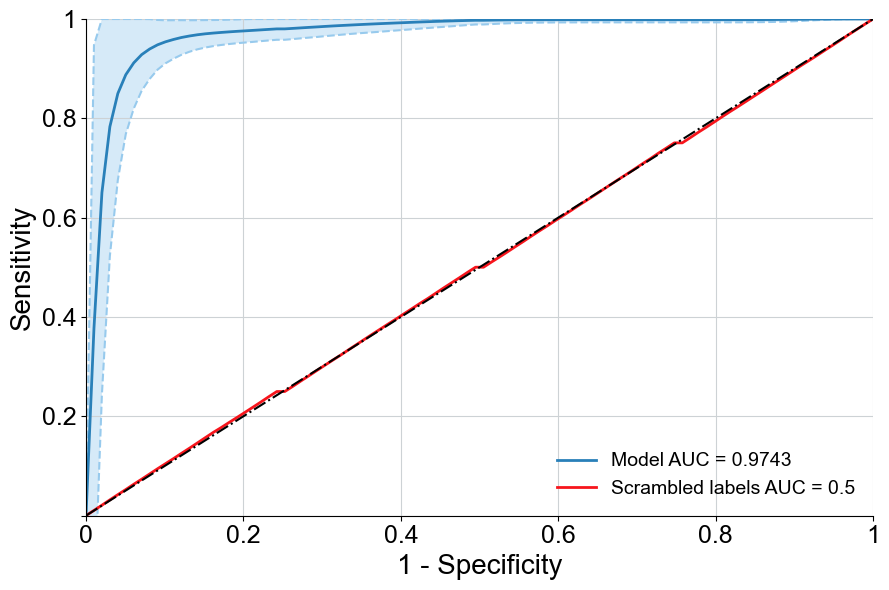

In [32]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [33]:
rf_fimp = bc.permutation_FIMP(data1, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [34]:
# rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

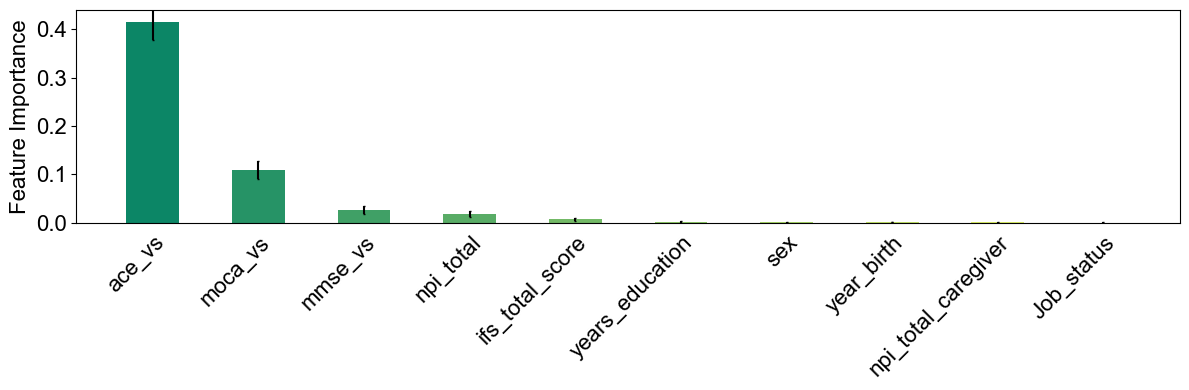

In [35]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

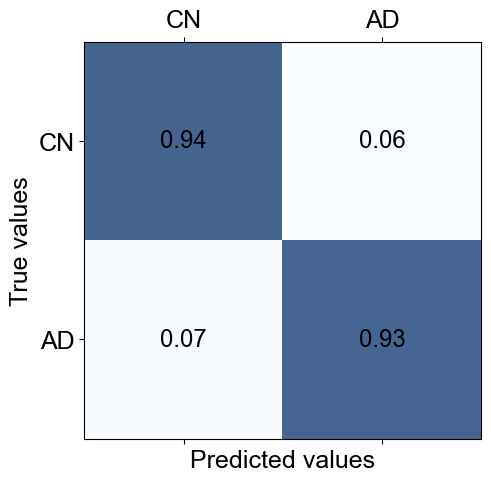

In [36]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['CN', 'AD'],fname=None)

#### unseen data

In [37]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [38]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [52]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [40]:
unseen_df = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [41]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9569
Accuracy: 0.9632
Recall: 0.9878
F1: 0.9701
Precision:0.9529


In [42]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9569
Bootstrping test ROC score: 	0.9743


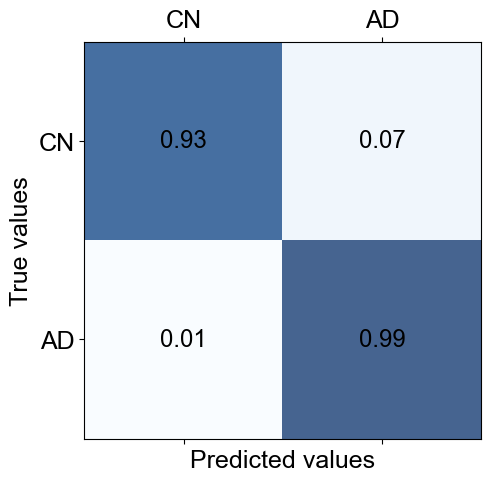

In [53]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'])

### RF Model

#### Bootstrap 1

In [44]:
Model_res1, CI_df1, Model_res_r1, ROC_AUC1, CM1, ROC_chance1, empirical_p_value1 = bc.Bootstrap_tree_classifier(
    data1, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params1, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features=1, min_samples_leaf=0.01,
                       min_samples_split=0.0765318248378294, n_estimators=500,
                       n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:19:51<00:00,  1.04it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:79.85844179391862 minutes
empirical p-value: 0.0


In [45]:
path_res2


'/home/marcelo/GitRepos/Tesis/pred_results/2023-12-05/mean_res/RandomForest_AD_vs_CN'

In [51]:
Model_res1.to_csv(path_res2+ "/Model_res1.csv", index=False)
Model_res1.mean()

Accuracy       0.935422
ROC_AUC        0.976859
Precision      0.960873
Recall         0.932431
Sensitivity    0.932431
Specificity    0.940114
F1             0.946288
Efron_pR2      0.733727
dtype: float64

In [54]:
print("%.4f" % Model_res1['ROC_AUC'].mean())

0.9769


In [55]:
CI_df1.to_csv(path_res2+ "/CI_df1.csv", index=False)
CI_df1

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.006813,0.004168,0.005375,0.006958,0.006958,0.006577,0.006249,0.012252


In [56]:
Model_res_r1.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/Model_res_r1.csv", index=False)
Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,ace_vs,0.231144,0.014573
9,moca_vs,0.215456,0.013826
8,mmse_vs,0.212171,0.013527
5,ifs_total_score,0.055378,0.004907
2,functionality,0.048214,0.004126
14,year_birth,0.040134,0.003797
11,npi_total,0.039074,0.003633
15,years_education,0.035382,0.003567
7,mini_sea_total,0.026738,0.002666
12,npi_total_caregiver,0.023248,0.002313


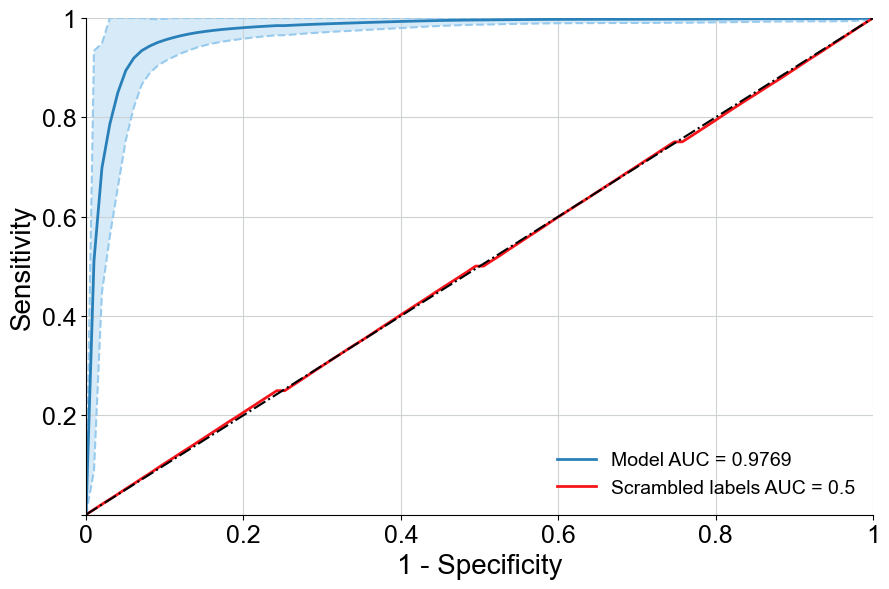

In [57]:
ml_plotting.plot_custom_roc_curve(ROC_AUC1, ROC_chance1, fname=path_res2+ "/ROC_AUC_curve1.png")

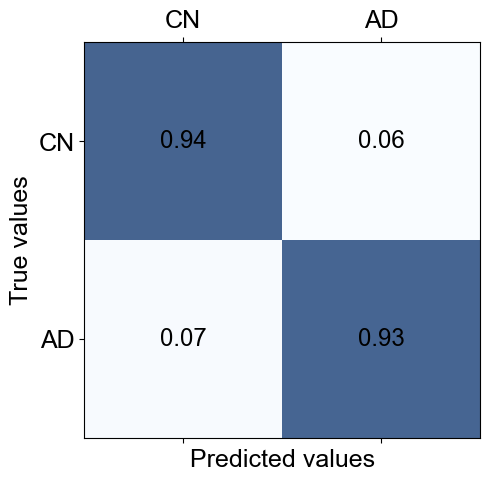

In [58]:
ml_plotting.plot_boostrap_CM(CM1, labels=['CN', 'AD'],fname=path_res2+ "/CM1.png")

##### Permutation Feature importance

In [59]:
rf_fimp1 = bc.permutation_FIMP(data1, 'diagnosis', RandomForestClassifier(), params=rf_params1, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [60]:
rf_fimp1.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI1.csv")
top_10p1 = rf_fimp1.sort_values('mean', ascending=False).head(10)

In [61]:
top_10p1

,predictor,mean,std
9,ace_vs,0.024987,0.006929
8,moca_vs,0.013395,0.005340
7,mmse_vs,0.008326,0.004620
10,functionality,0.004508,0.001451
3,ifs_total_score,0.004343,0.001826
4,mini_sea_total,0.002806,0.001245
5,npi_total,0.001854,0.001946
1,sex,0.001134,0.000920
6,npi_total_caregiver,0.000900,0.001495
12,n_children,0.000221,0.001284


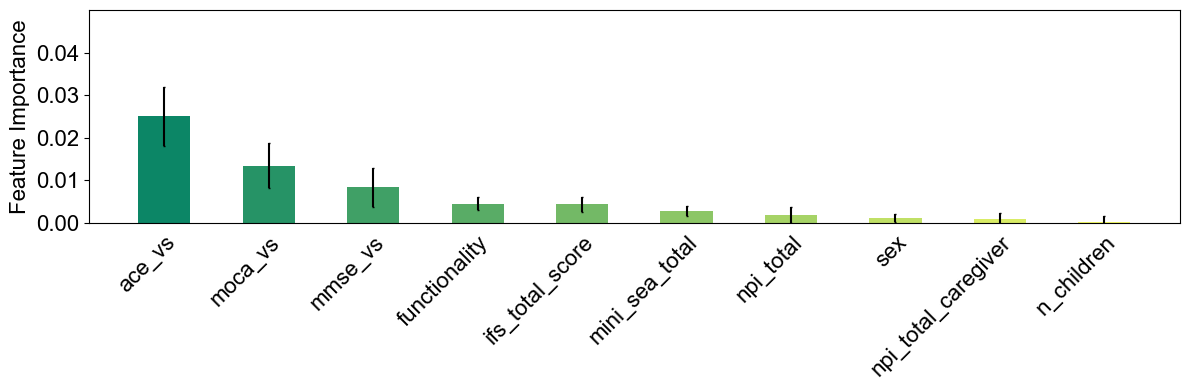

In [62]:
ml_plotting.plot_permutation_FIMP(top_10p1, names='predictor', importances_col='mean', std_col='std')

In [63]:
Model_res_r1.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,ace_vs,0.231144,0.014573
9,moca_vs,0.215456,0.013826
8,mmse_vs,0.212171,0.013527
5,ifs_total_score,0.055378,0.004907
2,functionality,0.048214,0.004126


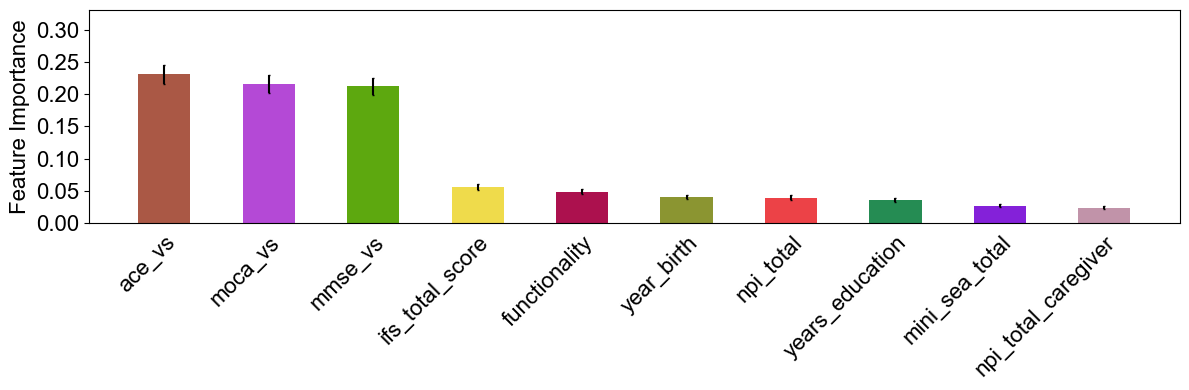

In [64]:
top_10_1 = Model_res_r1.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_1, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [65]:
X_train, y_train = data1.drop('diagnosis', axis=1), data1[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data1.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [66]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [67]:
# predict & scores
rfc = RandomForestClassifier(**rf_params1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [68]:
unseen_df1 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df1.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df1.to_csv(path_res+ "/unseen1.csv")

In [69]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9352
Accuracy: 0.9485
Recall: 1.0
F1: 0.9591
Precision:0.9213


In [70]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res1['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9352
Bootstrping test ROC score: 	0.9769


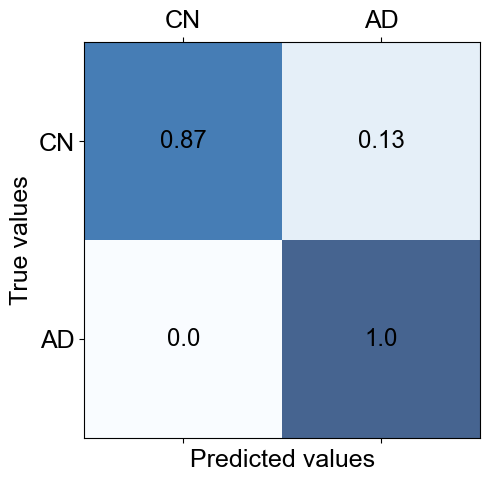

In [71]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'],fname=path_res2+ "/CM_unseen1.png")

#### Shapley

In [72]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

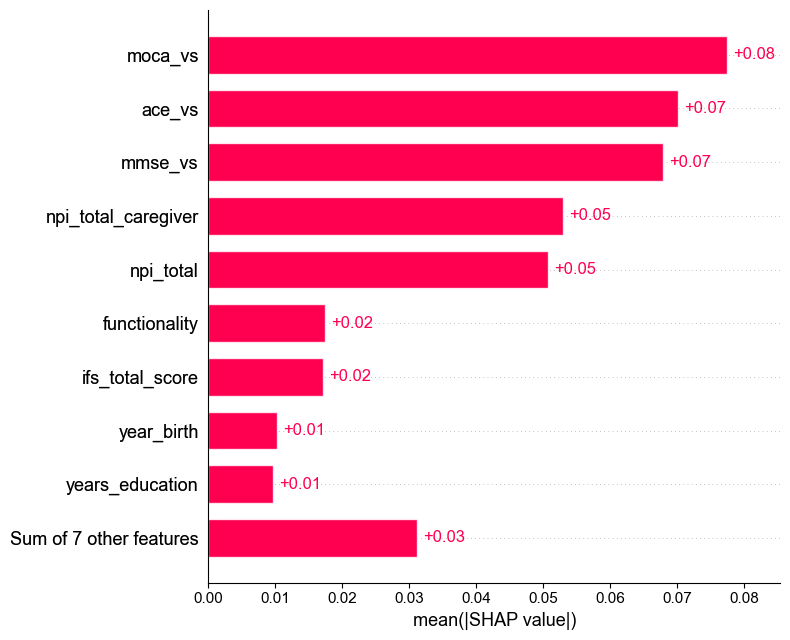

In [74]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 2

In [46]:
Model_res2, CI_df2, Model_res_r2, ROC_AUC2, CM2, ROC_chance2, empirical_p_value2 = bc.Bootstrap_tree_classifier(
    data2, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params2, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_features=1,
                       min_samples_leaf=0.01,
                       min_samples_split=0.0254811120350537, n_estimators=500,
                       n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:19:04<00:00,  1.05it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:79.0814172466596 minutes
empirical p-value: 0.0


In [77]:
Model_res2.to_csv(path_res2+ "/Model_res2.csv", index=False)
Model_res2.mean()

Accuracy       0.939597
ROC_AUC        0.977802
Precision      0.964994
Recall         0.935193
Sensitivity    0.935193
Specificity    0.946503
F1             0.949717
Efron_pR2      0.783902
dtype: float64

In [76]:
print("%.4f" % Model_res2['ROC_AUC'].mean())

0.9778


In [79]:
CI_df2.to_csv(path_res2+ "/CI_df2.csv", index=False)
CI_df2

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.006603,0.004084,0.005095,0.006824,0.006824,0.006237,0.006057,0.011408


In [80]:
Model_res_r2.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r2.csv", index=False)
Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
0,ace_vs,0.280646,0.016795
5,moca_vs,0.257466,0.016236
4,mmse_vs,0.254234,0.015983
2,ifs_total_score,0.061173,0.005405
1,functionality,0.052498,0.004512
6,npi_total,0.042114,0.003669
3,mini_sea_total,0.032246,0.003168
7,npi_total_caregiver,0.019621,0.001997


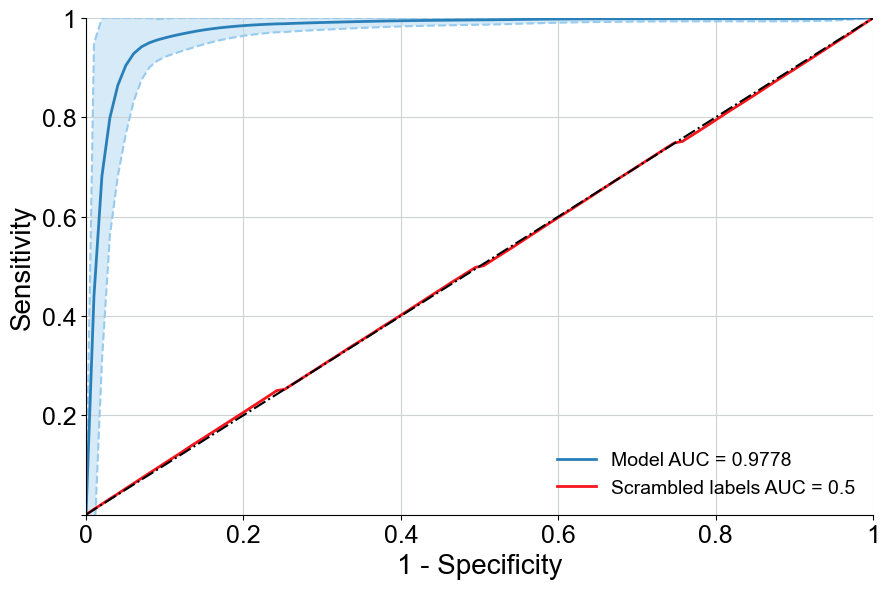

In [81]:
ml_plotting.plot_custom_roc_curve(ROC_AUC2, ROC_chance2, fname=path_res2+ "/ROC_AUC_curve2.png")

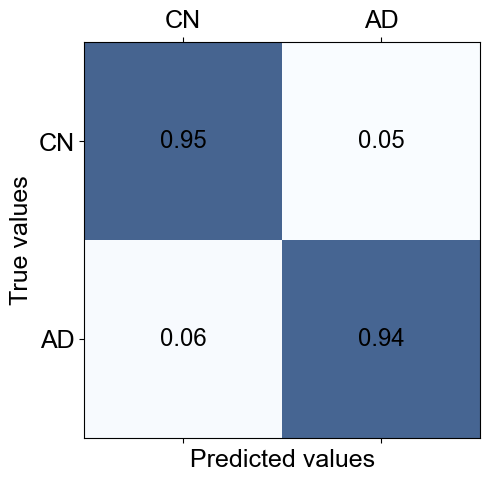

In [82]:
ml_plotting.plot_boostrap_CM(CM2, labels=['CN', 'AD'],fname=path_res2+ "/CM2.png")

##### Permutation Feature importance

In [85]:
rf_fimp = bc.permutation_FIMP(data2, 'diagnosis', RandomForestClassifier(),
                              params=rf_params2, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [86]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI2.csv")
top_10p2 = rf_fimp.sort_values('mean', ascending=False).head(10)

In [88]:
top_10p2

,predictor,mean,std
6,ace_vs,0.021141,0.007726
5,moca_vs,0.012859,0.006042
4,mmse_vs,0.008872,0.005773
7,functionality,0.005638,0.002087
0,ifs_total_score,0.004386,0.002391
1,mini_sea_total,0.003507,0.001777
2,npi_total,0.001301,0.002149
3,npi_total_caregiver,0.000573,0.001571


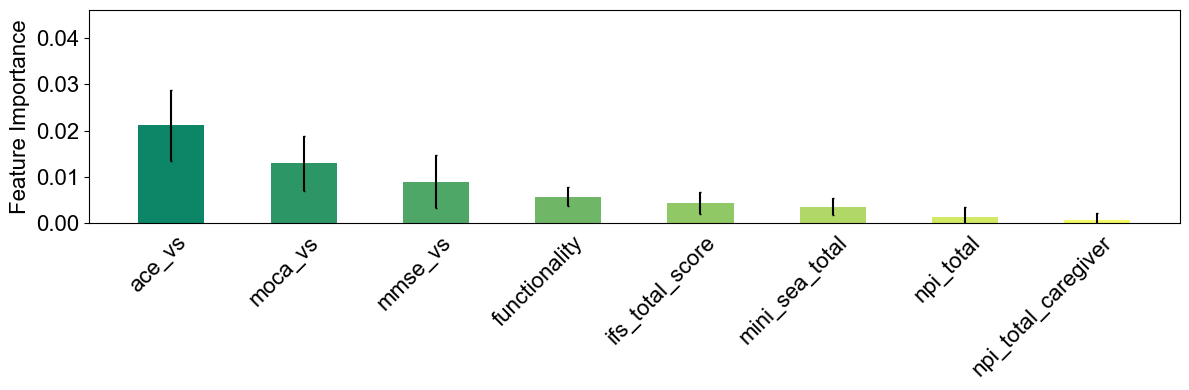

In [87]:
ml_plotting.plot_permutation_FIMP(top_10p2, names='predictor', importances_col='mean', std_col='std')

In [89]:
Model_res_r2.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
0,ace_vs,0.280646,0.016795
5,moca_vs,0.257466,0.016236
4,mmse_vs,0.254234,0.015983
2,ifs_total_score,0.061173,0.005405
1,functionality,0.052498,0.004512


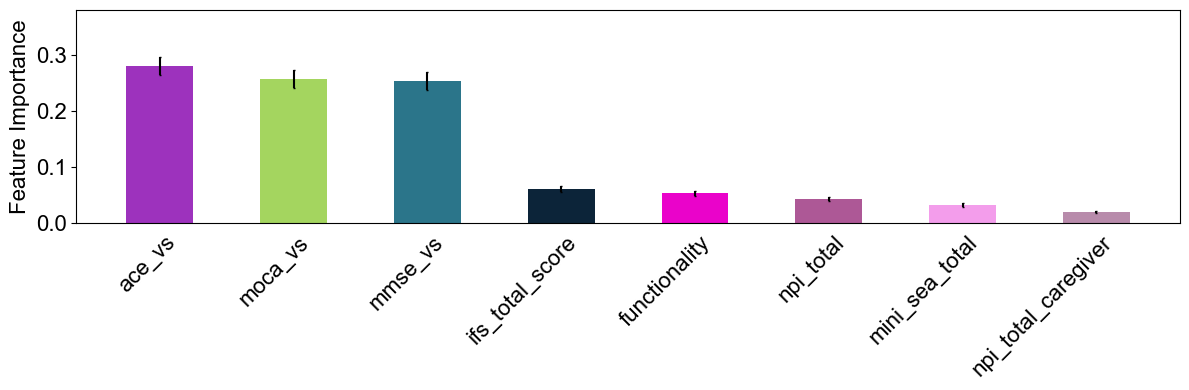

In [90]:
top_10_2 = Model_res_r2.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_2, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [96]:
X_train, y_train = data2.drop('diagnosis', axis=1), data2[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data2.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [ ]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [97]:
# predict & scores
rfc = RandomForestClassifier(**rf_params2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [98]:
unseen_df2 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df2.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df2.to_csv(path_res2+ "/unseen2.csv")

In [99]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9074
Accuracy: 0.9265
Recall: 1.0
F1: 0.9425
Precision:0.8913


In [100]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res2['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9074
Bootstrping test ROC score: 	0.9778


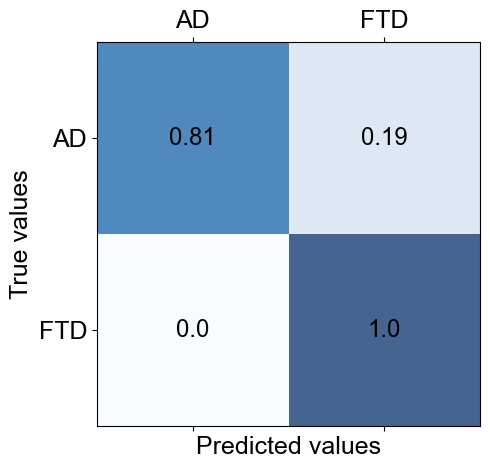

In [101]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['AD', 'FTD'],fname=path_res2+ "/CM_unseen2.png")

In [102]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

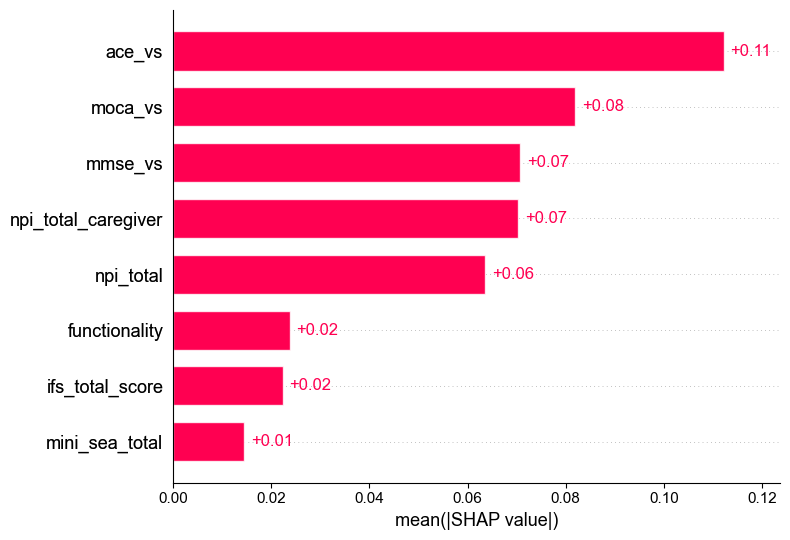

In [104]:
shap.plots.bar(shap_values[:,:,1])

#### Bootstrap 3

In [47]:
Model_res3, CI_df3, Model_res_r3, ROC_AUC3, CM3, ROC_chance3, empirical_p_value3 = bc.Bootstrap_tree_classifier(
    data3, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params3, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=6, min_samples_leaf=0.01,
                       min_samples_split=0.0945423795812129, n_estimators=500,
                       n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:19:35<00:00,  1.05it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:79.58955912590027 minutes
empirical p-value: 0.0


In [105]:
Model_res3.to_csv(path_res2+ "/Model_res3.csv", index=False)
Model_res3.mean()

Accuracy       0.927043
ROC_AUC        0.975608
Precision      0.955225
Recall         0.924111
Sensitivity    0.924111
Specificity    0.931640
F1             0.939219
Efron_pR2      0.772645
dtype: float64

In [106]:
print("%.4f" % Model_res3['ROC_AUC'].mean())

0.9756


In [107]:
CI_df3.to_csv(path_res2+ "/CI_df3.csv", index=False)
CI_df3

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.007209,0.004276,0.005732,0.00734,0.00734,0.006995,0.006623,0.011618


In [108]:
Model_res_r3.sort_values('Importance_mean', ascending=False).to_csv(path_res2+ "/Model_res_r3.csv", index=False)
Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
1,cognition,0.765316,0.010639
5,ifs_total_score,0.070229,0.006135
2,functionality,0.054027,0.006704
9,npi_total,0.037501,0.005250
12,year_birth,0.020674,0.004158
13,years_education,0.017745,0.003630
7,mini_sea_total,0.010555,0.002337
6,marital_status,0.006054,0.001494
8,n_children,0.005010,0.001188
0,Job_status,0.004476,0.001094


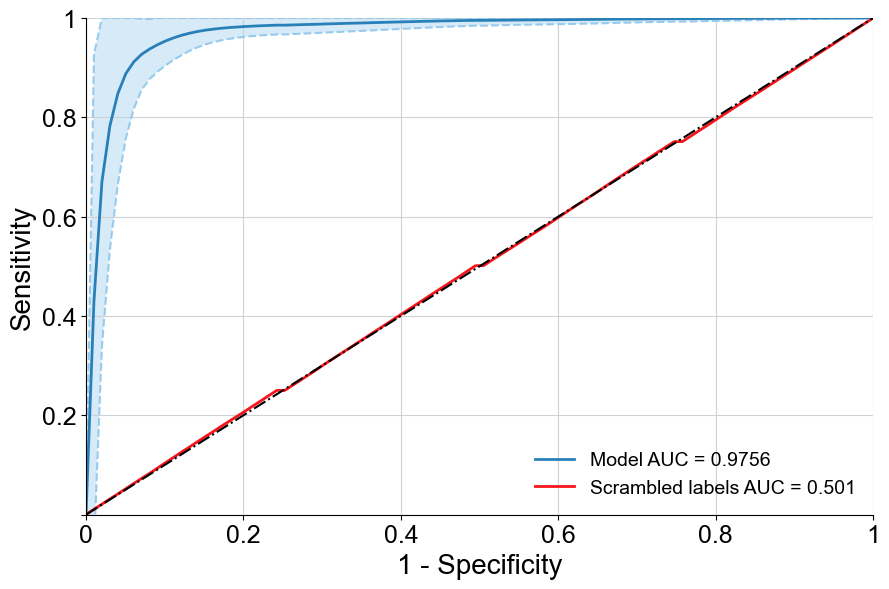

In [109]:
ml_plotting.plot_custom_roc_curve(ROC_AUC3, ROC_chance3, fname=path_res2+ "/ROC_AUC_curve3.png")

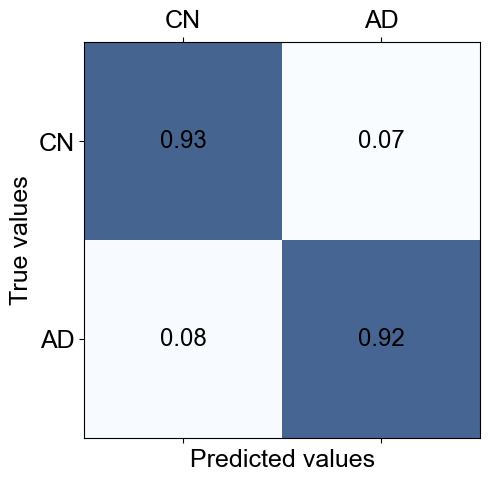

In [110]:
ml_plotting.plot_boostrap_CM(CM3, labels=['CN', 'AD'],fname=path_res2+ "/CM3.png")

##### Permutation Feature importance

In [111]:
rf_fimp3 = bc.permutation_FIMP(data3, 'diagnosis', RandomForestClassifier(), params=rf_params3, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [112]:
rf_fimp3.sort_values('mean', ascending=False).to_csv(path_res2+ "/rf_PFI3.csv")
top_10p3 = rf_fimp3.sort_values('mean', ascending=False).head(10)

In [113]:
top_10p3

,predictor,mean,std
7,cognition,0.333308,0.033651
8,functionality,0.011007,0.002458
3,ifs_total_score,0.008931,0.002184
5,npi_total,0.004075,0.002480
4,mini_sea_total,0.001142,0.000594
9,marital_status,0.000888,0.000958
6,npi_total_caregiver,0.000333,0.000210
1,sex,0.000327,0.000253
12,household_income,0.000323,0.000446
10,n_children,0.000316,0.000624


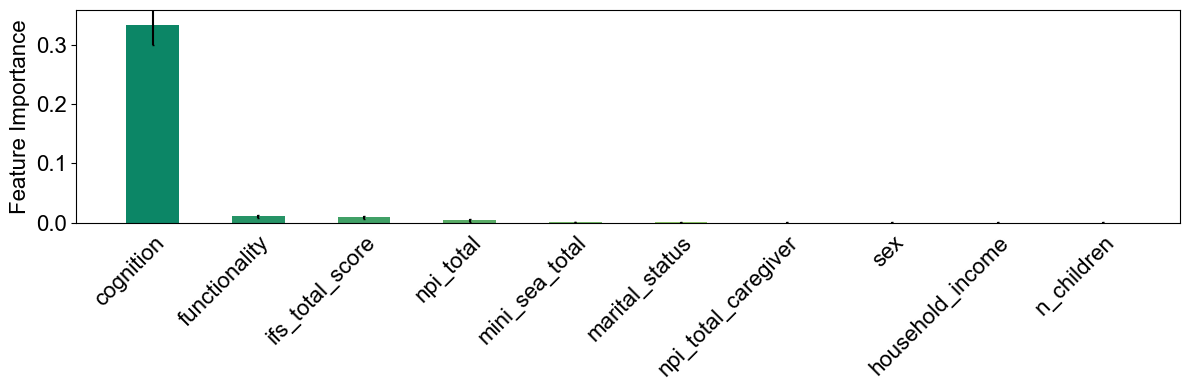

In [114]:
ml_plotting.plot_permutation_FIMP(top_10p3, names='predictor', importances_col='mean', std_col='std')

In [115]:
Model_res_r3.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
1,cognition,0.765316,0.010639
5,ifs_total_score,0.070229,0.006135
2,functionality,0.054027,0.006704
9,npi_total,0.037501,0.005250
12,year_birth,0.020674,0.004158


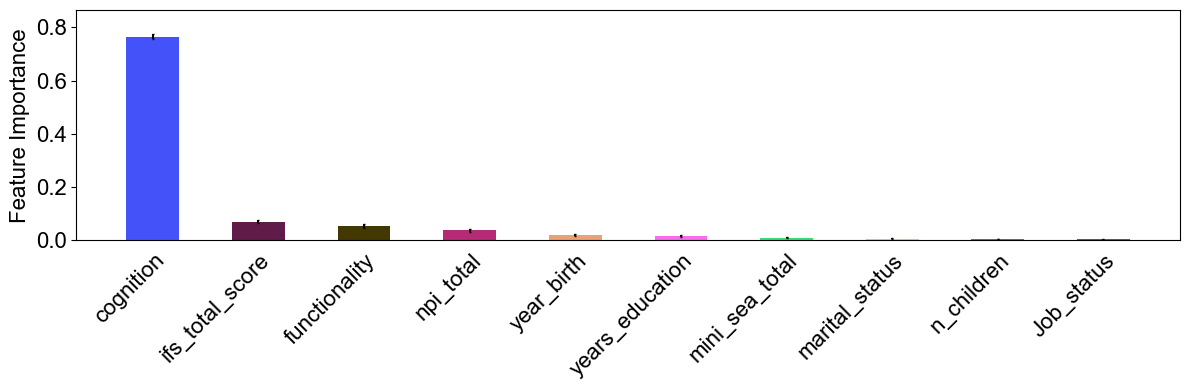

In [117]:
top_10_3 = Model_res_r3.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10_3, 'variables','Importance_mean', 'Importance_std')

##### unseen data


In [118]:
X_train, y_train = data3.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_unseen, y_unseen = unseen_data[data3.columns].drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [ ]:
scaler = MinMaxScaler(feature_range=(0.05, 0.95))
scaler=scaler.fit(X_train.iloc[:,:])
X_train.iloc[:,:] = scaler.transform(X_train.iloc[:,:])
X_unseen.iloc[:,:] = scaler.transform(X_unseen.iloc[:,:])

In [119]:
# predict & scores
rfc = RandomForestClassifier(**rf_params3)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_unseen)
roc = np.round(roc_auc_score(y_unseen, y_pred), 4)
acc = np.round(accuracy_score(y_unseen, y_pred), 4)
rec = np.round(recall_score(y_unseen, y_pred),4)
f1 = np.round(f1_score(y_unseen, y_pred), 4)
prec = np.round(precision_score(y_unseen, y_pred), 4)
cm = confusion_matrix(y_unseen, y_pred, normalize='true')

In [120]:
unseen_df3 = pd.DataFrame([roc, acc, cm[0,0],rec, f1, prec]).T
unseen_df3.columns= ['ROC AUC', 'Accuracy', 'Sensitivity','Recall', 'F1', 'Precision']
unseen_df3.to_csv(path_res2+ "/unseen3.csv")

In [121]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.9476
Accuracy: 0.9559
Recall: 0.9878
F1: 0.9643
Precision:0.9419


In [122]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res3['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.9476
Bootstrping test ROC score: 	0.9756


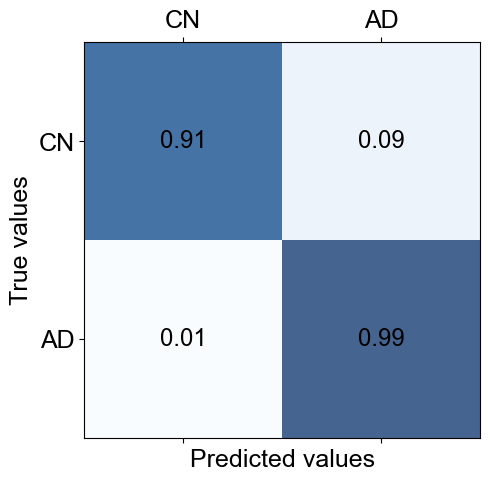

In [123]:
cm = {'TP':cm[0,0], 'FN':cm[0,1],
'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(cm, labels=['CN', 'AD'],fname=path_res2+ "/CM_unseen3.png")

In [124]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)


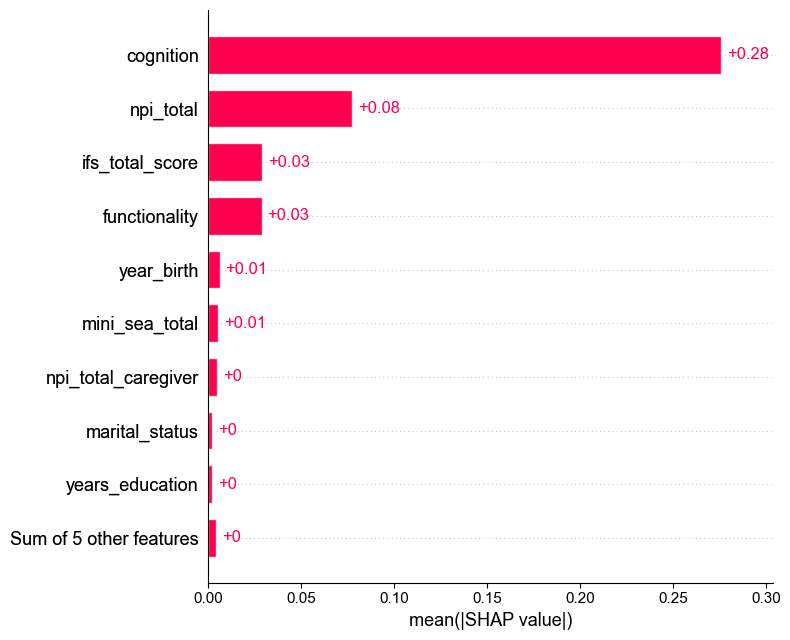

In [126]:
shap.plots.bar(shap_values[:,:,1])

### Sequential feature selector

#### RF

In [127]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [128]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [130]:
rf_params3['max_features'] =1

In [131]:
sfs_rfc = SFS(RandomForestClassifier(**rf_params3), 
           k_features='best', 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [132]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:    3.6s finished
Features: 1/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  13 | elapsed:    3.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:    3.8s finished
Features: 2/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.4s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.4s finished
Features: 3/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  11 | elapsed:    3.1s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    3.2s finished
Features: 4/14[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 

In [133]:
sfs_rf = pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

In [134]:
sfs_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)","[0.9017199017199017, 0.9459459459459459, 0.911...",0.919665,"(cognition,)",0.04274,0.018993,0.01343
2,"(5, 7)","[0.9066339066339066, 0.9508599508599509, 0.926...",0.927867,"(npi_total, cognition)",0.040726,0.018098,0.012797
3,"(3, 5, 7)","[0.9213759213759214, 0.9606879606879607, 0.926...",0.936057,"(ifs_total_score, npi_total, cognition)",0.039433,0.017523,0.012391
4,"(1, 3, 5, 7)","[0.9213759213759214, 0.9557739557739557, 0.931...",0.936061,"(sex, ifs_total_score, npi_total, cognition)",0.032598,0.014486,0.010243
5,"(1, 3, 5, 7, 8)","[0.9312039312039312, 0.9533169533169533, 0.933...",0.939339,"(sex, ifs_total_score, npi_total, cognition, f...",0.022341,0.009928,0.00702
6,"(1, 3, 5, 7, 8, 9)","[0.9336609336609336, 0.9606879606879607, 0.931...",0.941794,"(sex, ifs_total_score, npi_total, cognition, f...",0.03016,0.013403,0.009477
7,"(1, 3, 5, 6, 7, 8, 9)","[0.9385749385749386, 0.9606879606879607, 0.933...",0.944253,"(sex, ifs_total_score, npi_total, npi_total_ca...",0.026564,0.011804,0.008347
8,"(1, 3, 4, 5, 6, 7, 8, 9)","[0.9385749385749386, 0.9606879606879607, 0.931...",0.943432,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.028318,0.012584,0.008898
9,"(1, 3, 4, 5, 6, 7, 8, 9, 10)","[0.9385749385749386, 0.9656019656019657, 0.928...",0.944249,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.035198,0.015641,0.01106
10,"(1, 3, 4, 5, 6, 7, 8, 9, 10, 13)","[0.9361179361179361, 0.9606879606879607, 0.931...",0.942613,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.029137,0.012948,0.009156


In [ ]:
sfs_rf.loc[[5],:]

In [ ]:
# 5, 13
sfs_rf_features = list(sfs_rf.loc[5, 'feature_names'])

In [ ]:
sfs_rf_features

In [136]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

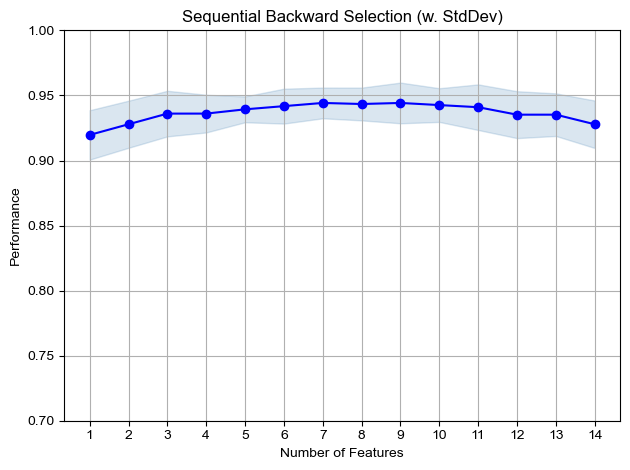

In [137]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.7, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

### Shapley

In [139]:
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_unseen, check_additivity=False)

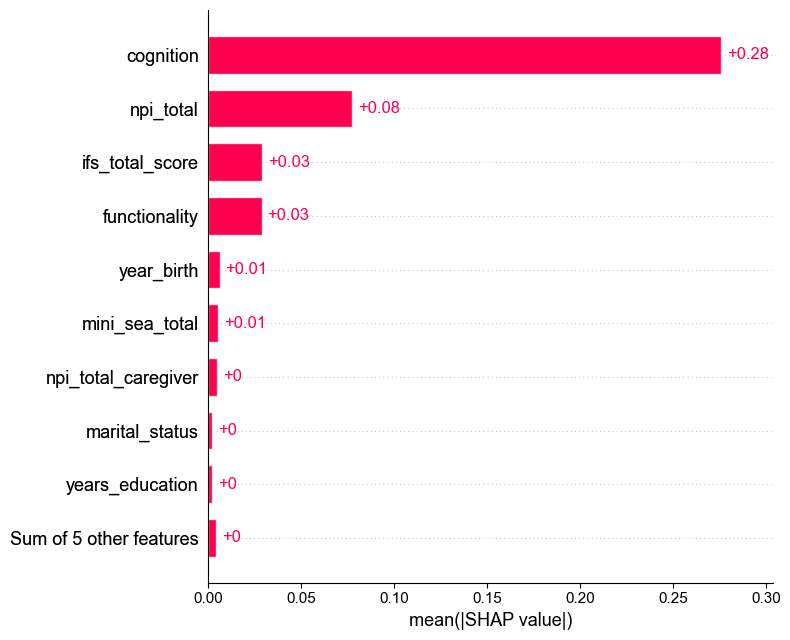

In [141]:
shap.plots.bar(shap_values[:,:,1])